In [1]:
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from torchvision import transforms
import pandas as pd
import numpy as np
import torch
from time import sleep
from tqdm import tqdm

pd.set_option('display.max_columns', 100)

d:\py36_dp\deeplearning\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
d:\py36_dp\deeplearning\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
d:\py36_dp\deeplearning\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
train = pd.read_csv('E:\\DL_datasets\\MNIST\\train.csv')
train_label = train.label
train.drop(['label'], axis=1, inplace=True)
test = pd.read_csv('E:\\DL_datasets\\MNIST\\test.csv')

trainX, testX, trainY, testY = train_test_split(train, train_label, test_size=0.2, random_state=42)

print('shape of train:', train.shape)
print('shape of test:', test.shape)
print('shape of trainX:', trainX.shape)
print('shape of trainY:', trainY.shape)
print('shape of testX:', testX.shape)
print('shape of testY:', testY.shape)

trainX = trainX / 255.0
testX = testX / 255.0
test = test / 255.0
trainY = trainY
testY = testY

# trainY = LabelBinarizer().fit_transform(trainY) / 1.0
# testY = LabelBinarizer().fit_transform(testY) / 1.0

trainX = torch.from_numpy(trainX.values).type(torch.FloatTensor)
trainY = torch.from_numpy(trainY.values).type(torch.LongTensor)
testX = torch.from_numpy(testX.values).type(torch.FloatTensor)
testY = torch.from_numpy(testY.values).type(torch.LongTensor)
test = torch.from_numpy(test.values).type(torch.FloatTensor)

shape of train: (42000, 784)
shape of test: (28000, 784)
shape of trainX: (33600, 784)
shape of trainY: (33600,)
shape of testX: (8400, 784)
shape of testY: (8400,)


In [4]:
trainY

tensor([6, 5, 3,  ..., 2, 6, 0])

In [5]:
batch_size = 64
epochs = 50
learning_rate = 1e-2

data_tf = transforms.Compose([
    transforms.ToTensor()
])

# 传入的数据必须为torch.Tensor类型的
trainX_dataset = TensorDataset(trainX, trainY)
testX_dataset = TensorDataset(testX, testY)
test_dataset = TensorDataset(test, torch.ones(test.size(0)))

trainX_loader = DataLoader(trainX_dataset, batch_size=batch_size, shuffle=True)
testX_loader = DataLoader(testX_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
test_loader

#### CNN

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        layer1 = nn.Sequential() # b, 1, 28, 28
        layer1.add_module('conv1', nn.Conv2d(1, 16, kernel_size=3)) # b, 16, 26, 26
        layer1.add_module('bn1', nn.BatchNorm2d(16))
        layer1.add_module('relu1', nn.ReLU(inplace=True))
        self.layer1 = layer1
        
        layer2 = nn.Sequential()
        layer2.add_module('conv2', nn.Conv2d(16, 32, kernel_size=3)) # n, 32, 24, 24
        layer2.add_module('bn2', nn.BatchNorm2d(32))
        layer2.add_module('relu2', nn.ReLU(inplace=True))
        layer2.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2)) # n, 32, 12, 12
        self.layer2 = layer2
        
        layer3 = nn.Sequential() 
        layer3.add_module('conv3', nn.Conv2d(32, 64, kernel_size=3)) # b, 64, 10, 10
        layer3.add_module('bn3', nn.BatchNorm2d(64))
        layer3.add_module('relu3', nn.ReLU(inplace=True)) 
        self.layer3 = layer3
        
        layer4 = nn.Sequential()
        layer4.add_module('conv4', nn.Conv2d(64, 128, kernel_size=3)) # n, 128, 8, 8
        layer4.add_module('bn4', nn.BatchNorm2d(128))
        layer4.add_module('relu4', nn.ReLU(inplace=True))
        layer4.add_module('pool4', nn.MaxPool2d(kernel_size=2, stride=2)) # n, 128, 4, 4
        self.layer4 = layer4
        
        fc = nn.Sequential()
        fc.add_module('fc1', nn.Linear(128*4*4, 1024))
        fc.add_module('fc_relu1', nn.ReLU(inplace=True))
        fc.add_module('fc2', nn.Linear(1024, 128))
        fc.add_module('fc_relu2', nn.ReLU(inplace=True))
        fc.add_module('fc3', nn.Linear(128, 10))
        self.fc = fc
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [8]:
model = CNN()
if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_losses = []
train_accs = []
val_losses = []
val_accs = []
for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0
    for data, label in trainX_loader:
        data = data.view(data.size(0), 1, 28, 28)
        if torch.cuda.is_available():
            data = Variable(data).cuda()
            label = Variable(label).cuda()
        else:
            data = Variable(data)
            label = Variable(label)
        
        out = model(data)
        loss = criterion(out, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item() * label.size(0)
        _, pred = torch.max(out, 1)
        train_acc += (pred == label).sum().item()
    
    val_loss = 0.0
    val_acc = 0
    for data, label in testX_loader:
        data = data.view(data.size(0), 1, 28, 28)
        if torch.cuda.is_available():
            data = Variable(data).cuda()
            label = Variable(label).cuda()
        else:
            data = Variable(data)
            label = Variable(label)
            
        out = model(data)
        loss = criterion(out, label)
        val_loss += loss.data.item() * label.size(0)
        _, pred = torch.max(out, 1)
        val_acc += (pred == label).sum().item()
    
    train_losses.append(train_loss/len(trainX_dataset))
    train_accs.append(train_acc/len(trainX_dataset))
    val_losses.append(val_loss/len(testX_dataset))
    val_accs.append(val_acc/len(testX_dataset))
    print("Epoch [{}/{}], train_loss:{:.6f}, train_acc:{:.6f}; val_loss:{:.6f}, val_acc:{:.6f}".format(epoch+1, epochs, 
                                                                      train_loss/len(trainX_dataset),
                                                                      train_acc/len(trainX_dataset),
                                                                      val_loss/len(testX_dataset),
                                                                      val_acc/len(testX_dataset)))

Epoch [1/50], train_loss:0.502299, train_acc:0.894137; val_loss:0.132255, val_acc:0.964167
Epoch [2/50], train_loss:0.098010, train_acc:0.972649; val_loss:0.082360, val_acc:0.976667
Epoch [3/50], train_loss:0.066911, train_acc:0.981161; val_loss:0.065397, val_acc:0.980952
Epoch [4/50], train_loss:0.051590, train_acc:0.985179; val_loss:0.053801, val_acc:0.984405
Epoch [5/50], train_loss:0.041954, train_acc:0.988214; val_loss:0.047773, val_acc:0.985119
Epoch [6/50], train_loss:0.035625, train_acc:0.990149; val_loss:0.043067, val_acc:0.986786
Epoch [7/50], train_loss:0.030240, train_acc:0.991607; val_loss:0.040883, val_acc:0.987381
Epoch [8/50], train_loss:0.026147, train_acc:0.993214; val_loss:0.037101, val_acc:0.988095
Epoch [9/50], train_loss:0.022885, train_acc:0.993839; val_loss:0.039679, val_acc:0.987738
Epoch [10/50], train_loss:0.019598, train_acc:0.995149; val_loss:0.035502, val_acc:0.988571
Epoch [11/50], train_loss:0.016727, train_acc:0.996280; val_loss:0.032885, val_acc:0.9892

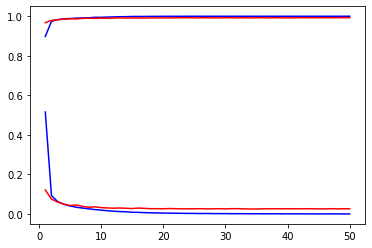

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accs)+1)
plt.plot(epochs, train_accs, 'b', label='train_acc')
plt.plot(epochs, train_losses, 'b', label='train_loss')
plt.plot(epochs, val_accs, 'r', label='val_acc')
plt.plot(epochs, val_losses, 'r', label='val_loss')
plt.show()

In [32]:
model.eval()
val_acc = 0
val_loss = 0.0

for data, label in tqdm(testX_loader):
    data = data.view(data.size(0), 1, 28, 28)
    if torch.cuda.is_available():
        data = Variable(data).cuda()
        label = Variable(label).cuda()
    else:
        data = Variable(data)
        label = Variable(label)

    out = model(data)
    loss = criterion(out, label)
    val_loss += loss.data.item() * label.size(0)
    _, pred = torch.max(out, 1)
    val_acc += (pred == label).sum().item()

print("Test loss:{:.6f}, test acc:{:.6f}".format(val_loss/len(testX_dataset), val_acc/len(testX_dataset)))

100%|███████████████████████████████| 132/132 [00:01<00:00, 78.80it/s]


Test loss:0.026664, test acc:0.992381


In [41]:
model.eval()
result = torch.LongTensor()
for data, label in test_loader:
    data = data.view(data.size(0), 1, 28, 28)
    if torch.cuda.is_available():
        data = Variable(data).cuda()
    else:
        data = Variable(data)
    
    out = model(data)
    _, pred = torch.max(out, 1)
    result = torch.cat((result, pred.cpu()), dim=0)

result

tensor([2, 0, 9,  ..., 3, 9, 2])

In [42]:
result = pd.DataFrame({'ImageId':range(1, result.size(0)+1), 'Label':result.numpy()})
result.to_csv('result_0912.csv', index=False)

In [17]:
from time import sleep
import tqdm

In [26]:
for i in tqdm(range(100)):
    sleep(0.1)

100%|███████████████████████████████| 100/100 [00:10<00:00,  9.86it/s]


In [27]:
with tqdm(total=100) as pbar:
    for i in range(10):
        sleep(0.2)
        pbar.update(10)

100%|███████████████████████████████| 100/100 [00:02<00:00, 49.65it/s]


In [33]:
torch.utils.data.random_split?